# Hamiltonian Monte Carlo (HMC) method
In this assignment, we will implement HMC method. Specifically 
1. Sample from one-dimensional exponential distribution $X \sim Exp(\lambda), \quad \text{where } \lambda = 2$.
2. the number of leapfrog steps $L = 25$. 
3. Initially use step size of $\epsilon = 0.1$.
4. constraint: sample only for $x \geq 0$ since $Exp(\cdot)$ is only defined there.

## 1. Derive the correct form $U(q)$
For $q \in \mathbb{R}^+$, we know the target distribution to sample is

$$
p(\boldsymbol{q}) = \lambda e^{-\lambda q} = \text{exp}\left(-\frac{U(q)}{T}\right)
$$ 

Thus that 

$$
U(q) = -T \ln p(q) = -T (\ln \lambda - \lambda q) = \lambda q - \ln \lambda 
$$

Here we choose $T = 1$. 

## 2. Write down all functions for HMC algorithm 
Important implementation details: 
1. for each iteration, we start from current position $q_0$ and velocity $p_0$ sampled from $\mathcal{N}(0, 1)$ </br>
    - `random.random()`, `random.uniform(0, 1)`: uniform;
    - `np.random.normal()`: normal.
2. Leapfrog Method: propgate $p$ in half steps. 
3. constraint is imposed at every HMC step, right after the half step of $p$ and full step of $q$. </br>
    - intuitively, we map the sample to the valid side of bound, and invert the momentum direction. 
4. at the end of each iteration, we update $q_0 = q^*$ if the proposed is accepted, otherwise $q_0$ remains. 
5. and the updated $q_0$ is the sample we obtain for this iteration. <span style='color: red'>no matter the proposed was accepted or not!</span>

In [1]:
import random 
import math 
import time 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class HMC4Exp:
    def __init__(self, 
                lam: float=2, 
                L: int=25, 
                eps: float=0.5):
        '''Hamiltonian Monte Carlo algorithm for one-dimensional Exp(2)
        Args: 
        ----
        lam: rate parameter for the exponential distribution 
        L: number of leapfrog steps
        eps: step size'''
        self.lam = lam 
        self.L = L
        self.eps = eps
        # full step for momentum is constant; save some calculation 
        self.p_full_step = eps * lam 

    def pdf_exp(self, x):
        '''probability density of Exp for validation.'''
        return self.lam*np.exp(-self.lam*x)
    
    def potential_energies(self, q): 
        return self.lam*q - math.log(self.lam) # U(q)
    
    def kinetic_energies(self, p): 
        return p**2/2 # K(p)
    
    def acceptance_rate(self, U0, K0, U, K): 
        return math.exp(U0 - U + K0 - K)
    
    def __call__(self, num_samples: int=int(1e6)):
        '''HMC sampling. 
        Hamilton dynamics: 
        dp/dt = dU/dq = lam, dq/dt = dK/ dp = p
        '''
        st = time.time()
        q0 = 0 
        samples = list()
        num_accept = 0
        for _ in range(num_samples):
            q = q0 # NOTE q0 is current q 
            p0 = np.random.normal() # current p. NOTE: normal, NO random.random() 
            p = p0 
            # alternate full steps for position and momentum 
            for i in range(self.L): 
                # make a half step for momentum 
                p -= self.p_full_step/2 # dp/dt = dU/dq
                # make a full step for the position 
                q += self.eps * p 
                # NOTE: where we impose constraints 
                # q has a lower constraint: q >= 0
                if q < 0: 
                    q = -q 
                    p = -p 
                    
                # make a half step for the momentum
                p -= self.p_full_step/2
            # negate momentum at the end of trajectory to make the proposal symmetric
            p = -p
            # evaluate potential and kinetic energies at start and end of trajectory 
            U0, K0 = self.potential_energies(q0), self.kinetic_energies(p0)
            U, K = self.potential_energies(q), self.kinetic_energies(p)
            # accept or reject the proposed state
            # NOTE: random.random(): uniform = random.uniform(0, 1)
            if random.uniform(0, 1) < self.acceptance_rate(U0, K0, U, K): 
                num_accept += 1
                q0 = q # NOTE: update current q 
            samples.append(q0)
                
        et = time.time()
        print(f'Sampling finished. Time used: {et-st: .3f}s, acceptance ratio: {num_accept/num_samples*100: .3f}%')
        return samples

## 3. Write down the constraint for this case
We impose constraint at every HMC step, so that the trajectory would not go to the region where the constriant does not hold after $L$ steps. 

Specifically, constraint checking and instructions on $p, q$ are imposed right after the half step for momentum and the full step for the position; Then we make a half step for momentum. 

$q$ has a lower constraint $q \geq 0$, when $q < 0$, we let $q = 0 + (0-q) = -q$ and $p = -p$. (Intuitively, we map the location to the valid side, and change the direction of momentum)

```python
# The number of leapfrop step is L
for i in range(self.L):                 
    # make a half step for momentum    
    p -= self.p_full_step/2 # dp/dt = dU/dq   
    # make a full step for the position 
    q += self.eps * p 
                
    # NOTE: where we impose constraints 
    # q has a lower constraint: q >= 0
    if q < 0: 
        q = -q 
        p = -p 
                      
    # make a half step for the momentum
    p -= self.p_full_step/2
```

## 4. Simulate $Exp(2)$ using your HMC. Use $10^6$ samples. Plot the distribution as a histogram together with the pdf of $Exp(2)$
### 4.0. Report the $\epsilon$ that will give a reasonable alignment. 
With temperature $T = 1$, we grid-search different steps ($\epsilon = [0.1, 0.2, \cdots, 1]$, **we can see that the $Exp(2)$ is well approximated in all plots; while the accpetance ratio, i.e.sampling efficiency decreases.**

**Therefore, we can use the default step size $\epsilon = 0.1$.**

step size = 0.1
Sampling finished. Time used:  8.450s, acceptance ratio:  90.766%
step size = 0.2
Sampling finished. Time used:  8.451s, acceptance ratio:  75.449%
step size = 0.3
Sampling finished. Time used:  8.589s, acceptance ratio:  59.451%
step size = 0.4
Sampling finished. Time used:  8.560s, acceptance ratio:  46.372%
step size = 0.5
Sampling finished. Time used:  8.523s, acceptance ratio:  36.149%
step size = 0.6
Sampling finished. Time used:  8.533s, acceptance ratio:  28.384%
step size = 0.7
Sampling finished. Time used:  8.566s, acceptance ratio:  22.541%
step size = 0.8
Sampling finished. Time used:  8.639s, acceptance ratio:  17.972%
step size = 0.9
Sampling finished. Time used:  8.612s, acceptance ratio:  14.571%
step size = 1
Sampling finished. Time used:  8.171s, acceptance ratio:  11.894%


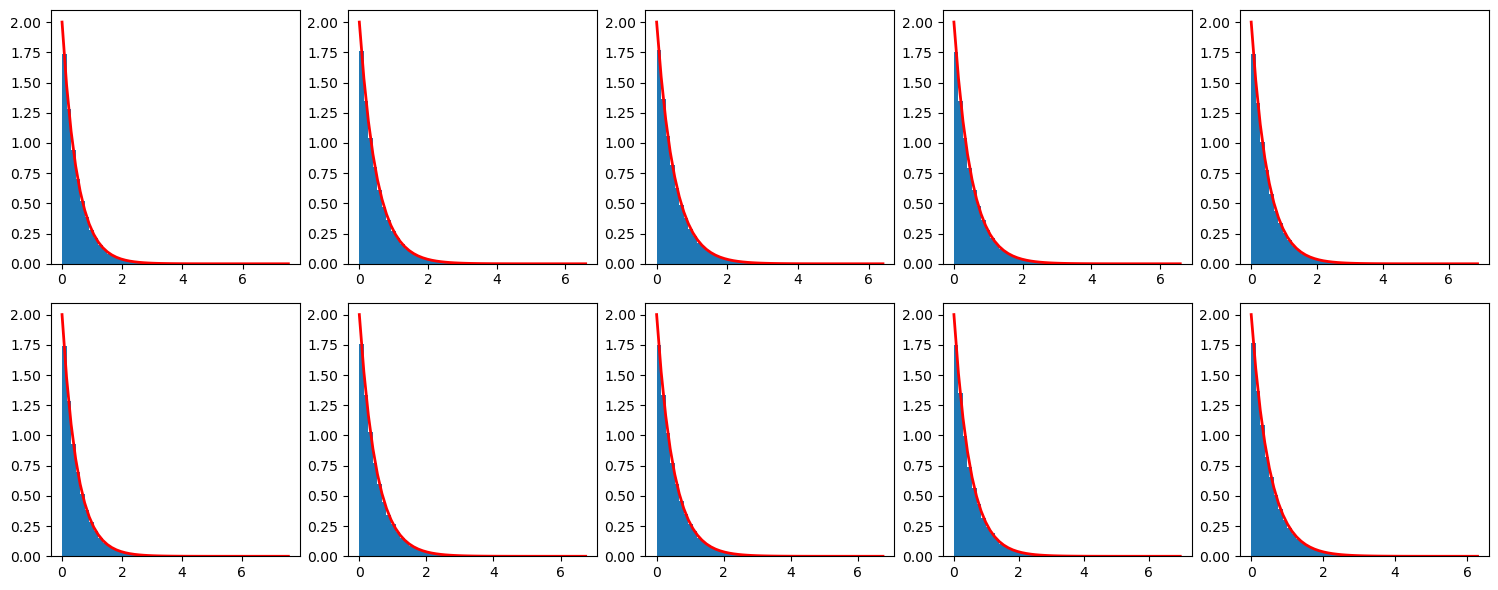

In [3]:
eps_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
fig, axs= plt.subplots(2, 5, figsize=(15, 6))
axs = axs.ravel()

for idx, eps in enumerate(eps_list):   
    hmc_exp = HMC4Exp(eps=eps)
    print(f'step size = {eps}')
    samples =hmc_exp()
    # histogram 
    count, bins,_ = axs[idx].hist(samples, bins=50, density=True, label='HMC Sampling')
    
    y = hmc_exp.pdf_exp(bins)
    axs[idx].plot(bins, y, linewidth=2, color='r', label='Exp')
    
plt.tight_layout()

### 4.1. Plot the distribution as a histogram together with the pdf of $Exp(2)$
with $\epsilon = 0.1$, the histogram and pdf is shown below. 

Sampling finished. Time used:  8.372s, acceptance ratio:  90.737%


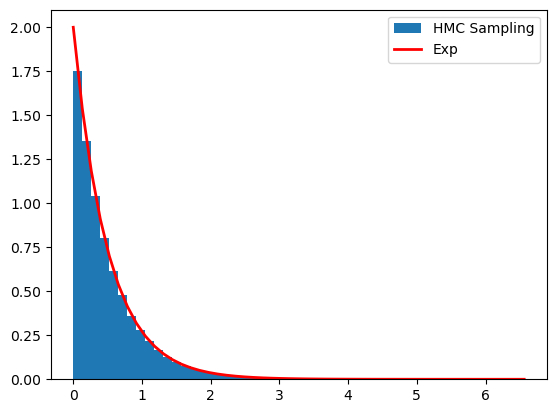

In [5]:
reasonable_eps = 0.1
hmc_exp = HMC4Exp(eps=reasonable_eps)
samples =hmc_exp()
fig, axs = plt.subplots()
# histogram 
count, bins,_ = axs.hist(samples, bins=50, density=True, label='HMC Sampling')
    
y = hmc_exp.pdf_exp(bins)
axs.plot(bins, y, linewidth=2, color='r', label='Exp')
axs.legend()

## Notes for myself
### MCMC
Probability and energy: Gibbs canonical distribution
$$
p(x) \propto \text{exp}\left(-\frac{U(\boldsymbol{x})}{T}\right)
$$
Probability $p(x)$ of a system to be in the state $x$ depends on the energy of the state $U(x)$ and temperature $T$. 

Any distribution can be rewritten as Gibbs canonical distribution. 

### Recall MH algorithm 
1. Sampling guarantees to converge: detailed balance, $\forall \boldsymbol{x}, \boldsymbol{x}',\quad p(\boldsymbol{x})p(\boldsymbol{x} \rightarrow \boldsymbol{x}') =  p(\boldsymbol{x}')p(\boldsymbol{x}' \rightarrow \boldsymbol{x})$
2. Problems: 
   - stepsize: too large - high rejection rate, too small - inefficient exploration.
   - inefficient in high-dimensional case due to random-walk behaviors.
3. Solution: HMC

### HMC 
   
Hamiltonian function gives the total energy of a dynamical system: 

$$
H(q, p) = U(q) + K(p), \quad K(p) = \frac{p^TM^{-1}p}{2} = \frac{p^Tp}{2}
$$

Where $q$ is the location, and $p$ is the velocity. Here we choose $M = 1$. 
#### Constraints 
1. Since Exponential distribution is only define for $x \geq 0$, we need to impose constriant on $q$. 
2. In order for the constraint to have minimal effect on the distribution to be imposed at every HMC step; Imposing after $L$ steps would lead to regions near the constraint (boundary) where the target distribution does not hold.

#### Python random number generator: `random.random()`, `random.uniform()`, and `np.random.normal`. 

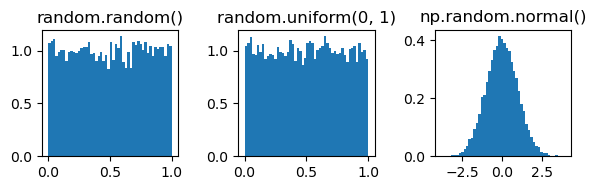

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(6, 2))
# 1. random.random
rr = [random.random() for _ in range(10000)]
count, bins,_ = axs[0].hist(rr, bins=50, density=True)
axs[0].set_title('random.random()')
# 2. random.uniform(0, 1)
ru = [random.uniform(0, 1) for _ in range(10000)]
count, bins,_ = axs[1].hist(ru, bins=50, density=True)
axs[1].set_title('random.uniform(0, 1)')
# 3. np.random.normal()
nrn = [np.random.normal() for _ in range(10000)]
count, bins,_ = axs[2].hist(nrn, bins=50, density=True)
axs[2].set_title('np.random.normal()')

plt.tight_layout()